### Training JLPT detection model to classify the difficulty of Japanese text  

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import math

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel

from models.attention import SimpleAttention


LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 20
LOAD_FROM = None
DATA_ROOT = Path("training_data")
NUM_CLASS = 5
EXP_FOLDER = Path("exp1")

/home/cyrus/virtualenv/text/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Dataset and Model

In [2]:
class TextDataset(Dataset):
    def __init__(self, df_path):
        super().__init__()
        self.df = pd.read_csv(df_path, index_col=0)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> tuple[str, int]:
        sentence = self.df["Sentence"][index]
        level = self.df["Level"][index]
        label = self.level2target(level)

        return sentence, label

    @classmethod
    def level2target(cls, level):
        return {"N1": 0, "N2": 1, "N3": 2, "N4": 3, "N5": 4}[level]

    @classmethod
    def target2name(cls, level):
        return ("N1", "N2", "N3", "N4", "N5")[level]

In [3]:
class ClassificationMetrics:
    def __init__(self, truths, outputs):
        """
        truths: (N), outputs: (N, C)
        """

        # process inputs
        truths_arr = np.array(truths).squeeze()
        outputs_arr = np.array(outputs).squeeze()

        self.truths = truths_arr  # ground truth predictions
        self._outputs = outputs_arr
        self.preds = np.argmax(outputs_arr, axis=1)

    def print_report(self, topK=None):
        accuracy = sklearn.metrics.accuracy_score(self.truths, self.preds)
        precision = sklearn.metrics.precision_score(self.truths, self.preds, average="macro", zero_division=0)
        recall = sklearn.metrics.recall_score(self.truths, self.preds, average="macro", zero_division=0)
        f1_score = sklearn.metrics.f1_score(self.truths, self.preds, average="macro", zero_division=0)

        if topK is None:
            print(f"Accuracy: {accuracy:2.2%} | Precision: {precision:.4f}")
            print(f"Recall:   {recall:.4f} | F1 score:  {f1_score:.4f}")
        else:
            topK_accuracy = sklearn.metrics.top_k_accuracy_score(self.truths, self._outputs, k=topK)
            print(f"Top 1 Accuracy: {accuracy:2.2%} | Top 5 Accuracy: {topK_accuracy:2.2%}")
            print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 score: {f1_score:.4f}")

In [4]:
train_dataset = TextDataset(DATA_ROOT / "train.csv")
# train_dataset = Subset(train_dataset, np.arange(500))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TextDataset(DATA_ROOT / "val.csv")
# val_dataset = Subset(val_dataset, np.arange(20))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = SimpleAttention(NUM_CLASS, vocab_size=len(tokenizer)).to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")  # to get average easily
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]")

    model.train()
    for batch_idx, (sentences, labels) in enumerate(train_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(f"[Batch {batch_idx:4d}/{len(train_loader)}] Loss: {loss.item()/BATCH_SIZE:.4f}")

    model.eval()
    val_loss = 0
    val_truths = []
    val_outputs = []
    for batch_idx, (sentences, labels) in enumerate(val_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_truths += labels.detach().cpu().tolist()
        val_outputs.append(outputs.detach().cpu())

    print(f"Total loss: {val_loss/len(train_dataset):.4f}")

    val_outputs = torch.cat(val_outputs)  # from list of tensor to numpy array
    metrics = ClassificationMetrics(val_truths, val_outputs)
    metrics.print_report()

    print()

Epoch [0/20]


### Visualize weights

In [ ]:
batch_idx, (sentences, labels) = next(enumerate(train_loader))
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
tokens_list = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]

model.eval()
_, attention = model.get_attention_output(**inputs)
cls_attn = attention[:, 0, :]
print(attention.shape)
print(cls_attn.sum())

for tokens, attn in zip(tokens_list, cls_attn):
    for t in tokens:
        print(f"{t:>15}", end="")
    print()
    for a in attn.tolist():
        print(f"{a:15.4f}", end="")
    print()

torch.Size([16, 42, 42])
tensor(16.0000, device='cuda:0', grad_fn=<SumBackward0>)
          [CLS]              そ            ##ん            ##な          [UNK]          [UNK]              、          [UNK]          [UNK]              の              王          [UNK]              、          [UNK]          [UNK]              と              同          [UNK]          [UNK]              に          [UNK]              す            ##る            ##ラ            ##イ            ##オ            ##ン            ##の          [UNK]              や          [UNK]          [UNK]          [UNK]          [UNK]          [UNK]          [UNK]          [UNK]              さ            ##な            ##い              。          [SEP]
         0.0225         0.0022         0.0179         0.0128         0.0170         0.0151         0.0012         0.0402         0.0377         0.0182         0.0214         0.0254         0.0012         0.0328         0.0321         0.0055         0.0086         0.0360         0.0349  

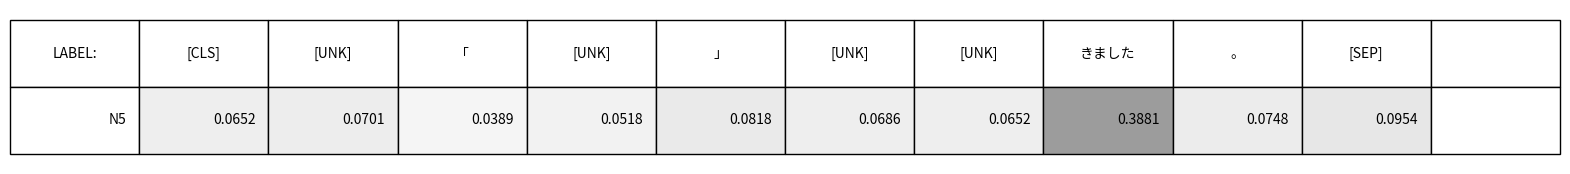

: 

In [ ]:
import matplotlib.font_manager as fm

fprop = fm.FontProperties(fname="resource/NotoSansJP-Regular.ttf")

i = 4
max_length = 12

tokens: list[str] = tokens_list[i]
attn = cls_attn[i].tolist()
label = TextDataset.target2name(labels[i].item())

words = []
values = []
for t, a in zip(tokens, attn):
    if t == "[PAD]":
        break
    if t.startswith("##"):
        # combine subwords
        words[-1] = words[-1] + t[2:]
        values[-1] += a
    else:
        words.append(t)
        values.append(a)

words = ["LABEL:"] + words
attn_strs = [label] + [f"{a:.4f}" for a in values]
colors = ["w"] + [str(1 - a) for a in values]


def plot_pairs(plt, words, values, colors, max_length=max_length):
    seq_length = len(words)
    if seq_length < max_length:
        words += [""] * (max_length - seq_length)
        values += [""] * (max_length - seq_length)
        colors += ["w"] * (max_length - seq_length)
    plt.axis("off")
    table = plt.table(cellText=[values], cellColours=[colors], colLabels=words, loc="center")
    for cell in table._cells:
        table._cells[cell].set_text_props(fontproperties=fprop)
    table.scale(1, 4)


num_lines = math.ceil(len(words) / max_length)
fig, ax = plt.subplots(num_lines, 1, figsize=(20, 2 * num_lines))
if num_lines == 1:
    plot_pairs(ax, words, attn_strs, colors)
else:
    for i in range(num_lines):
        s, e = i * max_length, (i + 1) * max_length
        plot_pairs(ax[i], words[s:e], attn_strs[s:e], colors[s:e])

plt.show()

In [ ]:
line = "Replace me by any text you'd like."
line2 = "Some weights of the model checkpoint at bert-base-cased were not used"
inputs = tokenizer([line, line2], return_tensors="pt", padding="max_length").to(DEVICE)
print(inputs.keys())
print(inputs["attention_mask"] == 0)
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"][1]))

out = model(**inputs)
print(out.shape)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='cuda:0')
['[CLS]', 'Rep', '##lace', 'me', 'by', 'any', 'text', 'you', "'", 'd', 'like', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '